<a href="https://colab.research.google.com/github/MandbeZ/TFM_sequia/blob/main/notebooks/4_2Modelos_Estad%C3%ADsticos_ML__SPI_SPEI_Multivariable(Por_estaci%C3%B3n).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Instalación de SKtime

In [ ]:
%pip install sktime
%pip install sktime[all_extras]
%pip install esig
%pip install utils

Importar librerías básicas

In [ ]:
import pandas as pd
import numpy as np
from sklearn import preprocessing
from sktime.utils.plotting import plot_series
from sktime.forecasting.base import ForecastingHorizon
from sktime.forecasting.model_selection import temporal_train_test_split


In [ ]:
#Definición de funciones
import matplotlib.pyplot as plt
from sktime.performance_metrics.forecasting import mean_absolute_percentage_error,\
                                                   mean_absolute_error, mean_squared_error
def evaluar_modelo(test,pred):
  print('MAPE:',mean_absolute_percentage_error(test, pred, symmetric=False)) 
  print('SMAPE:',mean_absolute_percentage_error(test, pred)) #symmetric default=True
  print('MAE:',mean_absolute_error(test, pred) )
  print('RMSE:',mean_squared_error(test, pred, square_root=True) ) # square_root=True RMSE , false MSE)
  print('MSE:',mean_squared_error(test, pred, square_root=False) ) # square_root=True RMSE , false MSE)

def graficar_modelo(train,test,pred,titulo='Modelo',inicio_serie=200):
  plot_series(train[inicio_serie:], test, pred, labels=["y_train", "y_test", "y_pred"])
  plt.axhline(y=0.5, color='r', linestyle='dashed')
  plt.title(titulo)
  plt.show()

'''Función que normaliza los datos entre 0 y 1''' 
def minmax_norm(df_sn):
    return (df_sn - df_sn.min()) / ( df_sn.max() - df_sn.min())

In [ ]:
df=pd.read_csv('https://raw.githubusercontent.com/MandbeZ/TFM_sequia/main/datos/indices_spi3_chirps_bc.csv', sep = ',', parse_dates=True)


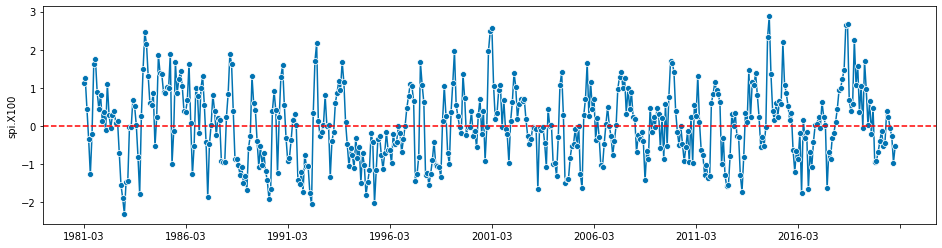

In [ ]:
'''Llevar la  fecha a índice, configurar como periodo'''
df['fecha']=pd.to_datetime(df['fecha'])
df.dropna(inplace=True)
df.set_index('fecha',inplace = True)
df.index=df.index.to_period("M")
plot_series(df['spi.X100'])
plt.axhline(y=0, color='r', linestyle='dashed')
plt.show()

In [ ]:
'''para mejores resultados se pueden normalizar los datos: [0,1]'''
df=minmax_norm(df)

Trabajar con una estación

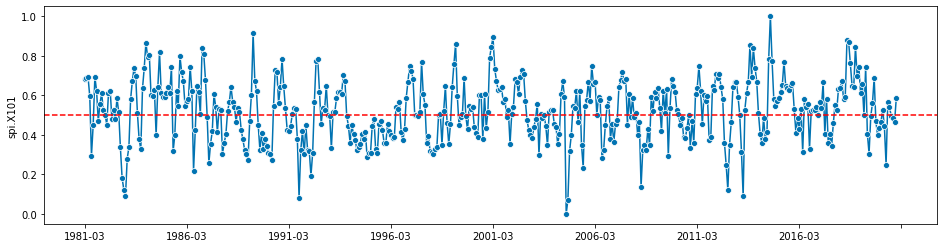

In [ ]:
serie=df.iloc[:,1]
plot_series(serie)
plt.axhline(y=0.5, color='r', linestyle='dashed')
plt.show()

# Una variable endógena con varias variables exógenas

In [ ]:
'''Funciones'''
'''Carga un dataframe elimina las n primeras filas y establece la fecha como índice'''
def cargar_series(ruta,nfilas): 
  '''nfilas es el número de filas que se eliminará del dataframe'''
  df=pd.read_csv('https://raw.githubusercontent.com/MandbeZ/TFM_sequia/main/datos/'+ruta, sep = ',', parse_dates=True)
  '''Configurar la fecha como datetime , índice y periodo'''
  df['fecha']=pd.to_datetime(df['fecha'])
  '''Eliminar nfilas'''
  df = df.iloc[nfilas:]
  df.set_index('fecha',inplace = True)
  df.index.name=None
  df.index=df.index.to_period("M")
  return(df)

'''Crea un dataframe de variables exógenas como X'''
def crear_exogenas(var1,var2,var3,esta):
  X=pd.DataFrame()
  X.set_index=var1.index
  X['tmed']=var1[esta]
  X['hmed']=var2[esta]
  X['noa']=var3['noa']
  return(X) 

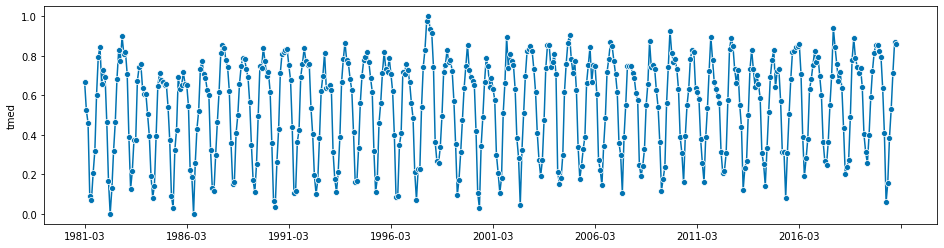

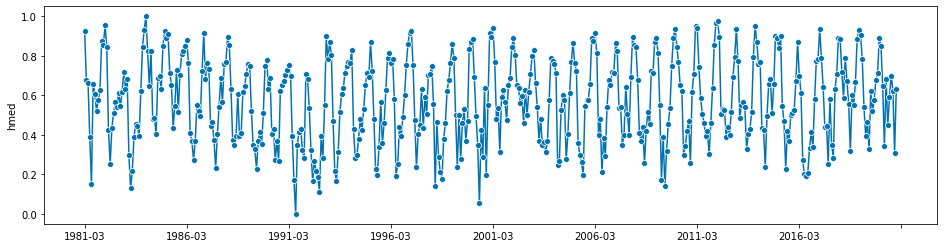

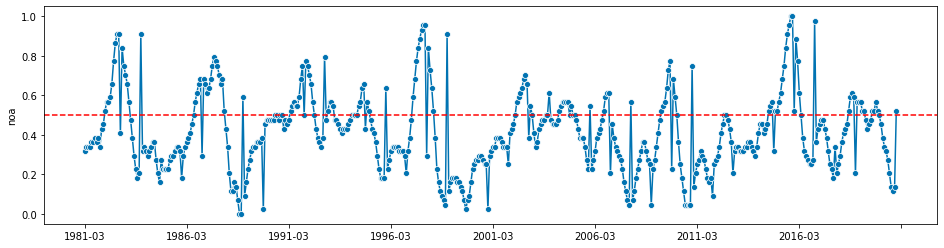

In [ ]:
import pandas as pd
import numpy as np
#Cargar el dataset de variables exógenas
tmed=cargar_series('nasa/nasa_mensual_tmed.csv',2)
hmed=cargar_series('nasa/nasa_mensual_hmed.csv',2)

#Cargar datos de NOA(Notebook) 
noa=pd.read_csv('https://raw.githubusercontent.com/MandbeZ/TFM_sequia/main/datos/nasa/DatosNAO.csv', sep = ',', parse_dates=True)
noa1=pd.melt(noa,id_vars=["Year"],value_vars=["12","1","2","3","4","5","6","7","8","9","10","11"],value_name="noa").sort_values(by="Year").reset_index(drop=True)
noa1['fecha']=pd.to_datetime(noa1['Year'].astype(str)+'-'+noa1['variable'].astype(str))
noa1.drop(['Year','variable'],axis=1,inplace=True)
noa1=noa1.sort_values(by="fecha").reset_index(drop=True)
#Fin notebook
noa1 = noa1.iloc[2:]
noa1.set_index('fecha',inplace = True)
noa1.index.name=None
noa1.index=noa1.index.to_period("M")
noa1
X=crear_exogenas(minmax_norm(tmed),minmax_norm(hmed),minmax_norm(noa1),'100')
spi=cargar_series('indices_spi3_chirps_bc.csv',2)
y=minmax_norm(spi).iloc[:,1] #1 es la estación 100"
plot_series(X['tmed'])
plot_series(X['hmed'])
plot_series(X['noa'])
plt.axhline(y=0.5, color='r', linestyle='dashed')
plt.show()

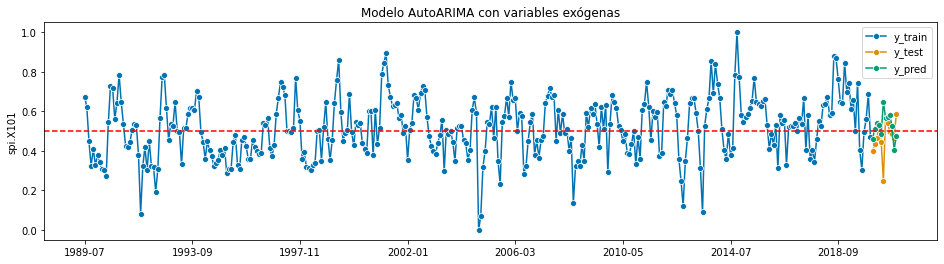

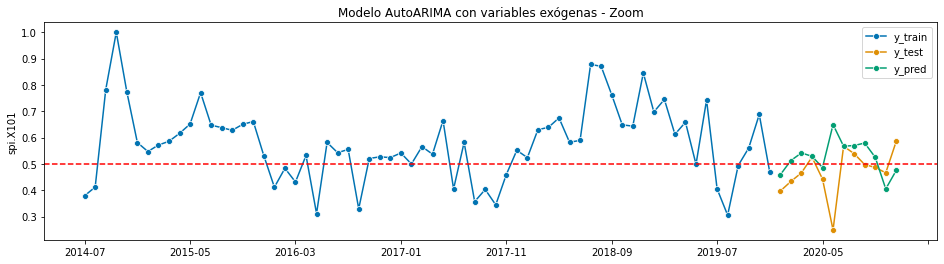

MAPE: 0.2358178689795304
SMAPE: 0.17375705099965466
MAE: 0.08224375916226549
RMSE: 0.1300015900763403
MSE: 0.01690041342237682


In [ ]:
from sktime.forecasting.arima import AutoARIMA
#AutoARIMA para SPI con variables exogenas
hpred = np.arange(12) + 1
y_train, y_test, X_train, X_pred = temporal_train_test_split(y, X, fh=hpred) #X representa las variables exógenas
predictor = AutoARIMA(suppress_warnings=True)
predictor.fit(y_train, X_train)
y_pred = predictor.predict(hpred, X=X_pred)
graficar_modelo(y_train,y_test,y_pred, 'Modelo AutoARIMA con variables exógenas',100)
graficar_modelo(y_train,y_test,y_pred, 'Modelo AutoARIMA con variables exógenas - Zoom',400)
evaluar_modelo(y_test, y_pred)

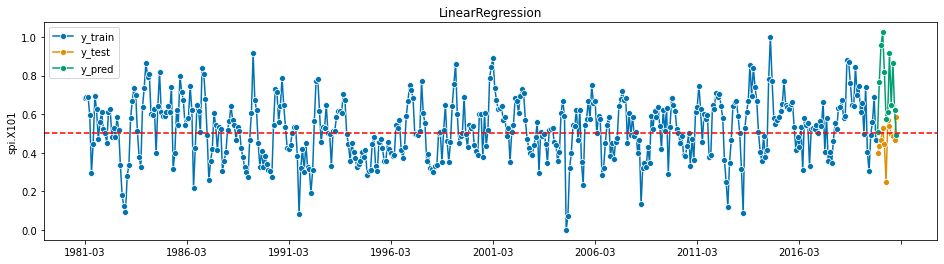

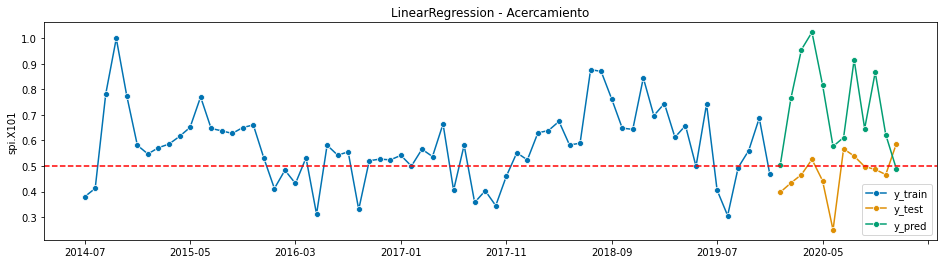

MAPE: 0.6298941171237525
SMAPE: 0.4498181329829494
MAE: 0.2780362705106097
RMSE: 0.31676655606509835
MSE: 0.1003410510413431


In [ ]:
#LinearRegression
from sklearn.linear_model import LinearRegression
from sktime.forecasting.compose import make_reduction
hpred = np.arange(12) + 1
y_train, y_test, X_train, X_pred = temporal_train_test_split(y, X, fh=hpred) #X representa las variables exógenas
regresor = LinearRegression()
predictor = make_reduction(regresor, strategy="recursive", window_length=72) #swindow_length=72
predictor.fit(y_train, X_train)
y_pred = predictor.predict(hpred,X=X_pred)
graficar_modelo(y_train,y_test,y_pred, 'LinearRegression',0)
graficar_modelo(y_train,y_test,y_pred, 'LinearRegression - Acercamiento',400)
evaluar_modelo(y_test, y_pred)

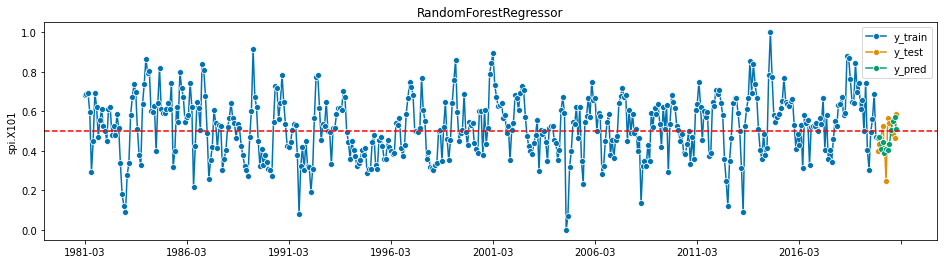

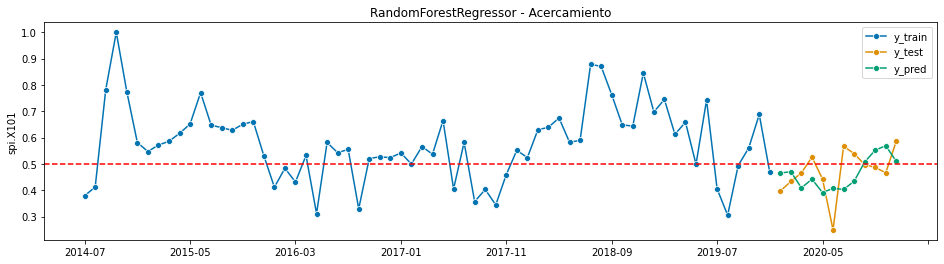

MAPE: 0.18973862034363018
SMAPE: 0.18205814491600145
MAE: 0.08156597365571347
RMSE: 0.09249678076826037
MSE: 0.008555654452491622


In [ ]:
#RandomForestRegressor
from sklearn.ensemble import RandomForestRegressor
from sktime.forecasting.compose import make_reduction
y_train, y_test, X_train, X_pred = temporal_train_test_split(y, X, fh=hpred) #X representa las variables exógenas
regresor = RandomForestRegressor(n_estimators=30)
predictor = make_reduction(regresor, strategy="recursive", window_length=48) #swindow_length=48
predictor.fit(y_train,X_train)
y_pred = predictor.predict(hpred,X=X_pred)
graficar_modelo(y_train,y_test,y_pred, 'RandomForestRegressor',0)
graficar_modelo(y_train,y_test,y_pred, 'RandomForestRegressor - Acercamiento',400)
evaluar_modelo(y_test, y_pred)

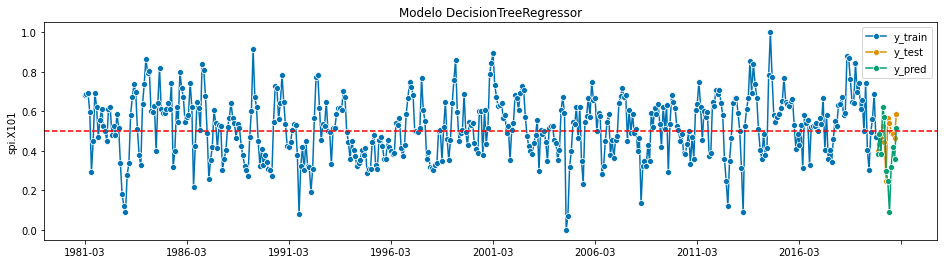

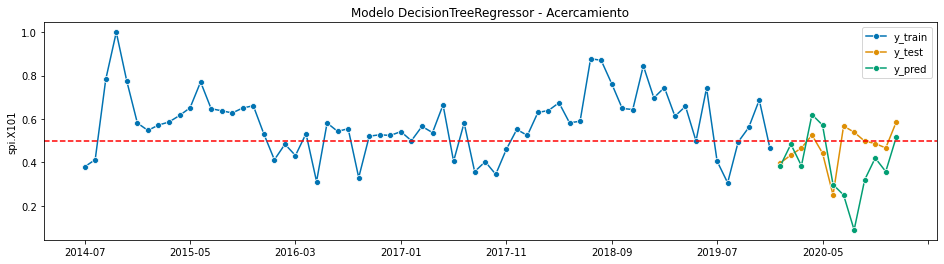

MAPE: 0.2695680188213432
SMAPE: 0.3436650836016948
MAE: 0.13418350153805572
RMSE: 0.1813926620696978
MSE: 0.032903297852731585


In [ ]:
#DecisionTreeRegressor
from sklearn.tree import DecisionTreeRegressor
from sktime.forecasting.compose import make_reduction
y_train, y_test, X_train, X_pred = temporal_train_test_split(y, X, fh=hpred) #X representa las variables exógenas
regresor = DecisionTreeRegressor()
predictor = make_reduction(regresor, strategy="recursive", window_length=48) #swindow_length=48
predictor.fit(y_train,X_train)
y_pred = predictor.predict(hpred,X=X_pred)
graficar_modelo(y_train,y_test,y_pred, 'Modelo DecisionTreeRegressor',0)
graficar_modelo(y_train,y_test,y_pred, 'Modelo DecisionTreeRegressor - Acercamiento',400)
evaluar_modelo(y_test, y_pred)

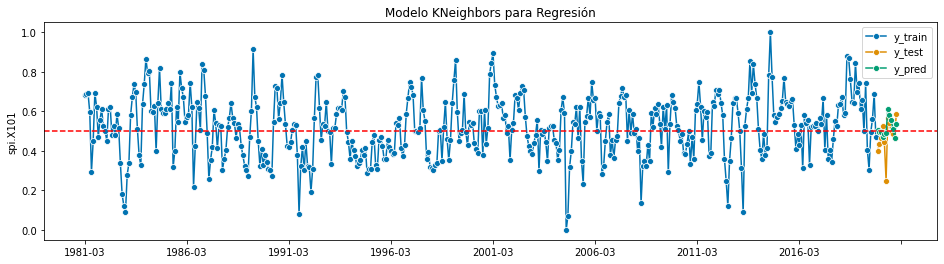

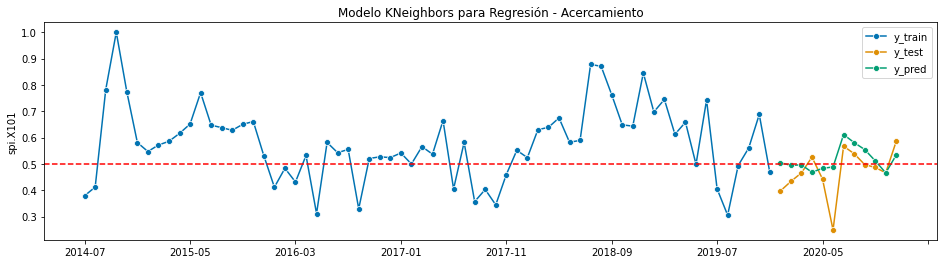

MAPE: 0.17063150450047057
SMAPE: 0.1405659166539661
MAE: 0.06308368265571639
RMSE: 0.08592756764996268
MSE: 0.007383546882238912


In [ ]:
#KNeighborsRegressor
from sklearn.neighbors import KNeighborsRegressor
from sktime.forecasting.compose import make_reduction
y_train, y_test, X_train, X_pred = temporal_train_test_split(y, X, fh=hpred) #X representa las variables exógenas
regresor = KNeighborsRegressor(n_neighbors=11)
predictor = make_reduction(regresor, strategy="recursive", window_length=48)
y_train, y_test = temporal_train_test_split(serie, fh=hpred)
predictor.fit(y_train,X_train)
y_pred = predictor.predict(hpred,X=X_pred)
graficar_modelo(y_train,y_test,y_pred, 'Modelo KNeighbors para Regresión',0)
graficar_modelo(y_train,y_test,y_pred, 'Modelo KNeighbors para Regresión - Acercamiento',400)
evaluar_modelo(y_test, y_pred)